## Cargar el modelo

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files 
from keras.preprocessing import image
import seaborn as sns

In [2]:
inceptionResNet_model = tf.keras.models.load_model('modelos/01_inception_final_v2')

2022-06-19 12:30:05.507626: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Evaluación del modelo

In [3]:
test_dir = "/Users/inma/Desktop/tfg/datos/test"
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_data = test_gen.flow_from_directory(test_dir,
                                           target_size = (224,224),
                                           class_mode = "categorical",
                                           batch_size = 32
                                          )

Found 1072 images belonging to 3 classes.


In [4]:
inceptionResNet_model_evaluation = inceptionResNet_model.evaluate(test_data)

34/34 [==============================] - 141s 4s/step - loss: 0.9085 - accuracy: 0.5233


### Comparación - Métricas de evaluación

#### 1. Accuracy

In [5]:
print(f"InceptionResNet Model Accuarcy : {inceptionResNet_model_evaluation[1] *100 : 0.2f}%")

InceptionResNet Model Accuarcy :  52.33%


Los resultados son mejores.

#### 2. Test Loss

In [6]:
print(f"InceptionResNet Model TestLoss : {inceptionResNet_model_evaluation[0] *100 : 0.2f}%")

InceptionResNet Model TestLoss :  90.85%


#### 3. ROC AUC

In [7]:
num_test = len(test_data.filenames)/64

labels = np_utils.to_categorical(np.array(test_data.classes), 3)

In [8]:
predictions_inception = inceptionResNet_model.predict(test_data)

##### Calcular auc:

In [9]:
roc_auc_all_inception = roc_auc_score(labels, predictions_inception)
print(f'InceptionResNet Model AUC: {roc_auc_all_inception *100 : 0.2f}%')

InceptionResNet Model AUC:  50.66%


## Visualizar resultados

#### Matriz de confusión

[Text(0, 0.5, 'melanoma'), Text(0, 1.5, 'nevus'), Text(0, 2.5, 'keratoses')]

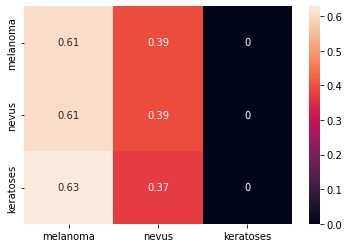

In [10]:
# Confusion matrix for all classes
y_true = test_data.classes
y_pred = [np.argmax(x) for x in predictions_inception]

labels = ["melanoma", "nevus", "keratoses"]
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize confusion matrix
ax = sns.heatmap(cm, annot=True)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)